# Challenge: Chest X-Ray Images (Pneumonia)
## General Project Overview
In this [Kaggle competion](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia?) a set of 5,863 chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients, between the age of one to five years old, in Guangzhou. All chest X-ray imaging was performed as part of the patient's routine clinical care. 

All chest radiographs were screened  by two expert physicians for quality control and removing all low quality or unreadable scans.

In the picture below are show the three type of chest X-ray present in the database: 
![alt](jZqpV51.png "Title")

On the left-hand side it is present an image of a __healthy indivudal__ with clear lungs and no areas of abnormal opacification. In the middle and right-hand side images are present a patient affected by __bacterial__ and __viral__ pneumonia respectively. The latter, presents a more diffuse ‘‘interstitial’’ pattern in both lungs. while the first typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows). 

For this particular challenge we are requested to discern only healthy vs pneumonia affected chest X-ray.

# Pneumonia

> Pneumonia is a form of acute respiratory infection that affects the lungs. When an individual has pneumonia, the lungs’ alveoli are filled with pus and fluid, which makes breathing painful and limits oxygen intake.
>
> Pneumonia is the single largest infectious cause of death in children worldwide. Pneumonia killed 808 694 children under the age of 5 in 2017, accounting for 15% of all deaths of children under five years old. [[Pneumonia - WHO]](https://www.who.int/news-room/fact-sheets/detail/pneumonia)
>
> More recently, the novel Covid-19 virus and the consequent pandemic has seen a dramatic increase in pneumonia cases all over the world and it is considered one of the most serious consequences of this new virus. [[George et al. (2020)]](https://thorax.bmj.com/content/early/2020/08/24/thoraxjnl-2020-215314) [[Pneumonia - NHS]](https://www.nhs.uk/conditions/pneumonia/)


## The dataset
This is a _manually cureted_ dataset of 5,863 X-Ray images, in JPEG format. 
The images are organized into __3 folders: (train, test, val)__. In each folder are two subfolders for each image category: `PNEUMONIA`, the pneumonia affected individual and `NORMAL` healthy patients. 

### Objectives
The objective of this kaggle challenge is a binary classification of images. Being a computer vision problem, I have chosen to use Convolutional Neural Network as a Deep Learning model for this challenge.

In [1]:
# Packages required:
import os
import numpy as np
import pandas as pd
from glob import glob 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, classification_report

np.random.seed(0)

# Identify the parent folder where all folders and files are contained 
base_dir = os.path.join(os.getcwd(), 'chest_xray')

## Build in Python 3.8.2
!python --version 

Python 3.8.2


# Exploratory Data Analysis
Before any attempt of creating a ML/DL model is good practice to start with an Exploratory Data Analysis (EDA) of the database. During this stage, we analyse the data set to summarise its main characteristics and gain major insight into its features using numerical analysis and visual methods.

In my experience in the healthcare and in the bioinformatics sectors, databases are usually particularly messy and noisy. Experimental and clinical data might come from many different sources (public or company databases), different laboratories following different protocols. It is imperative to be very careful with the data, check if the data provided are correct in the input phase and have multiple checks along the pipeline.

For this particular challenge, we are close to an idea scenario. We have got a manually curated dataset of high quality black-and-white pictures that do not require data cleaning, analysis of missing value, feature scaling, correlation analysis, etch. But I will proceed to the analysis of the data folder, and the images contained in it.

In [2]:
# Let's proceed with the analysis of the database that I've downloaded from keggle

# First let's check that the number of files matches the description in the webpage. So to check that all images are accounted for.
total_number = len(glob(os.path.join(base_dir,'*','*','*.jpeg')))
    
# Checking the folder structure
print("Data composition in folder chest_xray\n")
for folder in os.listdir(base_dir):
    num_of_jpeg = len(glob(os.path.join(base_dir, folder, "*", '*.jpeg')))
    print("{}:\t\t{} ({:.2f}% of total)".format(folder, num_of_jpeg, num_of_jpeg/total_number*100))
    for subfolder in os.listdir(os.path.join(base_dir, folder)):
        num_in_subfolder = len(glob(os.path.join(base_dir, folder, subfolder,'*.jpeg')))
        print(" - {}:\t  {} ({:.2f}%)".format(subfolder, num_in_subfolder, num_in_subfolder/num_of_jpeg*100))
        
print("\n For a total of {} .jpeg files.".format(total_number))

Data composition in folder chest_xray

test:		624 (10.66% of total)
 - PNEUMONIA:	  390 (62.50%)
 - NORMAL:	  234 (37.50%)
train:		5216 (89.07% of total)
 - PNEUMONIA:	  3875 (74.29%)
 - NORMAL:	  1341 (25.71%)
val:		16 (0.27% of total)
 - PNEUMONIA:	  8 (50.00%)
 - NORMAL:	  8 (50.00%)

 For a total of 5856 .jpeg files.


From the output above, we can see that the folder Train has got almost 90% of all images (89.07%) with the 3/4 of images being Pneumonia. While in the folder Test we have only 10% of all images, with 2/3 being labelled as pneumonia. And in the folder Val, there are present only 16 images in total.

In a normal machine learning analysis, it is good practice not to use the entire database to train our model but to split into subgroups and use only one of them at the time to train and the remaining for testing and validation.

In general, for small databases I prefer to create a k-cross-validation system, in which, iteratively, the whole dataset is used as part of train and test sets. While, for very large datasets, or those requiring great computational time, I prefer  to split the database into a training, testing and validation set.

For this exercise I choose to use a train/test/validation system. At this moment, with low computing power to perform a cross validation in a timely manner. Plus, given the nature of composition of the folders I have decided to rearrange the data and divide into a different ratio.

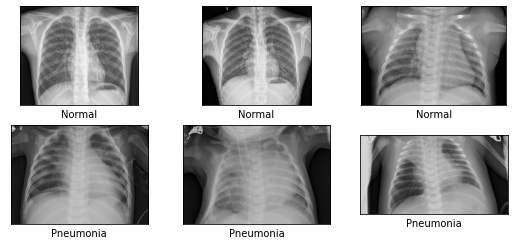

In [3]:
NORMAL = glob(os.path.join(base_dir,'*','NORMAL','*.jpeg'))
PNEUMONIA = glob(os.path.join(base_dir,'*','PNEUMONIA','*.jpeg'))

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 4))
for i in range(3):
    axes[0,i].set_xlabel('Normal')
    axes[0,i].imshow(mpimg.imread(NORMAL[i]), cmap='gray')
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])
    axes[1,i].set_xlabel('Pneumonia')
    axes[1,i].imshow(mpimg.imread(PNEUMONIA[i]), cmap='gray')
    axes[1,i].set_xticks([])
    axes[1,i].set_yticks([])
plt.show()

In the top row of the images above, we can see three examples of NORMAL images, those representing healthy individuals with clear lungs and no opacity. While the bottom row shows three PNEUMONIA individuals with infected and more opaque lungs.

Also we can notice that now all images have the same length/width ratio.

## Data preparation
First, I create a pandas dataframe that will contain the path to each of the imanges and the label associated with them.

In [4]:
# Dataframe with all images manually classified as healhy patients 
df_normal = pd.DataFrame({'Path': NORMAL, 'Class': 'NORMAL' })

# Dataframe with all images manually classified as patients wiht pneumonia
df_pneumonia = pd.DataFrame({'Path': PNEUMONIA, 'Class': 'PNEUMONIA' })

# The entire dataset of images
df = pd.concat([df_normal, df_pneumonia])

In [5]:
df.head()

,Path,Class
0,/Users/mattiacinelli/chestxray/chest_xray/test...,NORMAL
1,/Users/mattiacinelli/chestxray/chest_xray/test...,NORMAL
2,/Users/mattiacinelli/chestxray/chest_xray/test...,NORMAL
3,/Users/mattiacinelli/chestxray/chest_xray/test...,NORMAL
4,/Users/mattiacinelli/chestxray/chest_xray/test...,NORMAL


In [6]:
df.describe()

,Path,Class
count,5856,5856
unique,5856,2
top,/Users/mattiacinelli/chestxray/chest_xray/trai...,PNEUMONIA
freq,1,4273


### Train/test/validation split
Continue by dividing the dataset again in a determined ratio.
I will use 60% of the data as a training set, 20% for the validation and test sets.

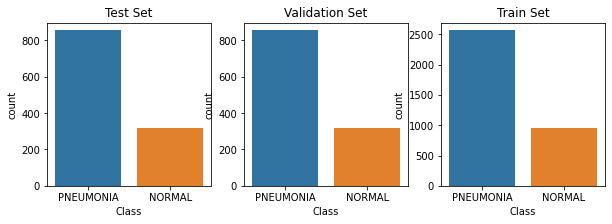

In [7]:
train_split = 0.4 # Majority of images for the train subset (60%)
X_train, X_val, y_train, y_val = train_test_split(
    df['Path'], df['Class'], 
    test_size = train_split, 
    stratify = df['Class'], # This parameter establishes a proportional split of values in the sample
    random_state=42)

val_test_split = 0.5 # Equal division for test and validation
X_test, X_val, y_test, y_val = train_test_split(
    X_val, y_val,  test_size = val_test_split, stratify = y_val, random_state=42)

train_set = pd.DataFrame({'Path': X_train, 'Class' : y_train})
val_set = pd.DataFrame({'Path': X_val, 'Class': y_val})
test_set = pd.DataFrame({'Path': X_test,'Class' : y_test})

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
sns.countplot(x="Class", data=test_set, ax=axes[0])
sns.countplot(x="Class", data=val_set, ax=axes[1])
sns.countplot(x="Class", data=train_set, ax=axes[2])

axes[0].set_title("Test Set")
axes[1].set_title("Validation Set")
axes[2].set_title("Train Set")
plt.show()

In [8]:
# Checking the folder structure
print("Data composition in rearranged sets\n")
for set_name, set_ in zip(['train_set', 'val_set', 'test_set'], [train_set, val_set, test_set]):
    print("{}:\t{} ({:.2f}% of total)".format(set_name, set_.shape[0], set_.shape[0]/total_number*100)) #
    for label in ['PNEUMONIA', 'NORMAL']:
        print(" - {}:\t  {} ({:.2f}%)".format(label, sum(set_.Class==label), set_[set_['Class']==label].shape[0]/set_.shape[0]*100))

Data composition in rearranged sets

train_set:	3513 (59.99% of total)
 - PNEUMONIA:	  2563 (72.96%)
 - NORMAL:	  950 (27.04%)
val_set:	1172 (20.01% of total)
 - PNEUMONIA:	  855 (72.95%)
 - NORMAL:	  317 (27.05%)
test_set:	1171 (20.00% of total)
 - PNEUMONIA:	  855 (73.01%)
 - NORMAL:	  316 (26.99%)


## Correct for data imbalance
In the now rearranged sets we have an equal ratio of Pneumonia/Normal images in each subsets. However, the dataset is indeed still imbalanced with a different number of Pneumonia/Normal images within each of the sets. 

This can be a potential problem, indeed with our current ratio, a model could reach 73% accuracy just by classifying everything as Pneumonia. To solve this problem, I compute the class weights to indicate an imbalance in our data to our model using the parameter `CLASS_WEIGHTS`.

In [9]:
pneumo_in_test = sum(train_set.Class=='PNEUMONIA')
normal_in_test = sum(train_set.Class=='NORMAL')

print("Pneumonia images count in training set: {}".format(pneumo_in_test))
print("Normal images count in training set: {}\n".format(normal_in_test))
print("Total number of images: {}\n".format(train_set.shape[0]))
print("Initial bias: {:.5f}\n".format(np.log([pneumo_in_test / normal_in_test])[0]))

weight_for_normal = (1 / normal_in_test) * (train_set.shape[0]) / 2.0
weight_for_pneumo = (1 / pneumo_in_test) * (train_set.shape[0]) / 2.0

print("Weight for class 0 (Normal): {:.2f}".format(weight_for_normal))
print("Weight for class 1 (Pneuom): {:.2f}".format(weight_for_pneumo))

class_weight = {0: weight_for_normal, 1: weight_for_pneumo}

# Alternativly we could have used sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(train_generator), train_generator)

Pneumonia images count in training set: 2563
Normal images count in training set: 950

Total number of images: 3513

Initial bias: 0.99247

Weight for class 0 (Normal): 1.85
Weight for class 1 (Pneuom): 0.69


The NORMAL images are underrepresented in the test set, therefore, they are weighted more. 

## Pre processing

In [10]:
rescale = 1./255 #  To get all the scaled data in the range [0, 1]
target_size = (150, 150) # The dimensions to which all images found will be resized. In this dataset, we have images of different size
batch_size = 32 # is the number of training instances observed before the optimizer performs a weight update.
class_mode = "binary"

## Data Augmentation
# We can artificially expand our training set with multiple types of transformation, including rotation, rescaling, horizontal or vertical flip, zooming, etch.
# This also contributes to avoid overfitting issues
train_datagen = ImageDataGenerator(
    rescale = rescale,
    rotation_range = 30, # Randomly rotating pictures, it takes values between 0-180
    shear_range = 0.2, # Shear Intensity
    zoom_range = 0.2, # Randomly zooming pictures
    horizontal_flip = True # Randomly flipping half of the images horizontally
)
train_generator = train_datagen.flow_from_dataframe( #Takes the dataframe and the path to a directory plus generates batches.
        dataframe = train_set, x_col = "Path", y_col = "Class", batch_size = batch_size,seed = 42,
        shuffle = True, # Randomly shuffles the input dataset
        class_mode = class_mode,target_size = target_size)

validation_datagen = ImageDataGenerator(rescale=rescale) # Data augmentation only for train set
validation_generator = validation_datagen.flow_from_dataframe(
        dataframe = val_set, x_col = "Path", y_col = "Class", batch_size = batch_size,
        seed = 42, shuffle = False, class_mode = class_mode, target_size = target_size)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_set, x_col = "Path", y_col = "Class", target_size=target_size,
    class_mode=class_mode, batch_size=batch_size, shuffle = False)

Found 3513 validated image filenames belonging to 2 classes.
Found 1172 validated image filenames belonging to 2 classes.
Found 1171 validated image filenames belonging to 2 classes.


## Creating the CNN Model

In [11]:
model= Sequential() # It initializes the neural network
model.add(Conv2D( # It makes a convolutional layer
    32, # The number of output filters in the convolution
    (3,3), # The feature detector
    input_shape=(150, 150, 3),
    activation='relu' # Rectified Linear Unit, the most comnly used activation function
                ))
model.add(MaxPooling2D(2,2)) # This enables the CNN to detect features irrespective of the difference in lighting and angles
    
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2)) # Randomly "switch-off" of neurons to avoid overfitting
    
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))
    
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
    
model.add(Flatten()) # Flattening transforms the entire pooled feature map matrix into a single column
model.add(Dropout(0.2))
model.add(Dense(256,activation='relu')) # The fully connected layer as in a hidden layer in ANNs
model.add(Dense(1,activation='sigmoid'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0

## Selecting the metrics 

In [12]:
metrics_ = [ # Choosing the metrics of evaluation for our model
    AUC(name='auc'), 
    BinaryAccuracy(name='accuracy'), 
    Precision(name="precision"),
    Recall(name="recall"), 
           ]

model.compile(
    optimizer = 'adam', # This optimizer uses a stochastic gradient descent method
    loss = 'binary_crossentropy', # For a binary classification problem
    metrics = metrics_)

## Callbacks

In [13]:
# This feature is used to save checkpoints of your model at regular intervals and recover in case of problems.
metric = 'auc'
checkpoint = ModelCheckpoint(
    filepath = 'chestxray_model.hdf5', 
    monitor = metric, 
    save_best_only = True)

# This feature is used to interrupt training when validation performance has stopped improving after a while.
early_stopping = EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

## Fitting the model

In [14]:
steps_per_epoch=len(train_generator)
validation_steps=len(validation_generator)
epochs = 10 # Number of times the training vectors are used to update weights

history_model = model.fit(
    train_generator,
    validation_data = validation_generator,
    
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    
    epochs = epochs,
    verbose = 1,
    callbacks = [checkpoint, early_stopping],
    
    class_weight=class_weight)

Epoch 1/10
110/110 [==============================] - 159s 1s/step - loss: 0.6933 - auc: 0.5706 - accuracy: 0.4569 - precision: 0.7678 - recall: 0.3664 - val_loss: 0.7906 - val_auc: 0.9119 - val_accuracy: 0.2807 - val_precision: 1.0000 - val_recall: 0.0140
Epoch 2/10
110/110 [==============================] - 155s 1s/step - loss: 0.4800 - auc: 0.8553 - accuracy: 0.7660 - precision: 0.9093 - recall: 0.7546 - val_loss: 0.6285 - val_auc: 0.9618 - val_accuracy: 0.7014 - val_precision: 0.9941 - val_recall: 0.5942
Epoch 3/10
110/110 [==============================] - 148s 1s/step - loss: 0.3240 - auc: 0.9362 - accuracy: 0.8659 - precision: 0.9524 - recall: 0.8591 - val_loss: 0.2893 - val_auc: 0.9709 - val_accuracy: 0.8899 - val_precision: 0.9814 - val_recall: 0.8655
Epoch 4/10
110/110 [==============================] - 139s 1s/step - loss: 0.3311 - auc: 0.9329 - accuracy: 0.8639 - precision: 0.9480 - recall: 0.8607 - val_loss: 0.3407 - val_auc: 0.9698 - val_accuracy: 0.8703 - val_precision: 

## Model Performance

In [15]:
result  = model.evaluate(test_generator, steps=len(test_generator), 
                         verbose=False, return_dict=True)

print("The model trained has a result for:\nArea Under the Curve of {:.3f}\n\
\nAn Accuracy of {:.2f}%\nPrecison {:.2f}% and \nRecall of {:.2f}%".format(
    result['auc'],
    result['accuracy']*100,
    result['precision']*100,
    result['recall']*100
))

The model trained has a result for:
Area Under the Curve of 0.985

An Accuracy of 92.49%
Precison 97.76% and 
Recall of 91.81%


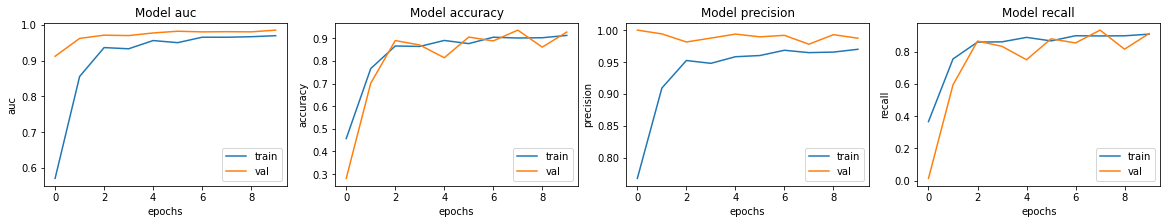

In [16]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["auc",  "accuracy", "precision", "recall"]):
    ax[i].plot(history_model.history[met])
    ax[i].plot(history_model.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [17]:
predictions = model.predict(test_generator, batch_size = batch_size, steps=len(test_generator), verbose=0)
pred_classes =  (model.predict(test_generator, batch_size = batch_size) > 0.5).astype("int32")

In [18]:
print(classification_report(test_generator.labels, pred_classes))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87       316
           1       0.98      0.92      0.95       855

    accuracy                           0.92      1171
   macro avg       0.89      0.93      0.91      1171
weighted avg       0.93      0.92      0.93      1171



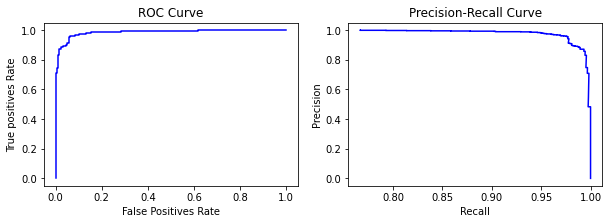

In [19]:
fpr, tpr, _ = roc_curve(test_generator.labels, predictions)
pre, rec, _ = precision_recall_curve(test_generator.labels, predictions)

fig, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].plot(fpr, tpr, 'b')
ax[0].set_xlabel('False Positives Rate')
ax[0].set_ylabel('True positives Rate')
ax[0].set_title('ROC Curve')

ax[1].plot(pre, rec, 'b') 
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall Curve')

plt.show()

The numerical values of AUC and binary accuracy and the ROC curve plot shows that the image classification task was performed with high level of success, even with low number of convolutional layers and epochs.

# Source 
- Deep learning with Tensorflow 2 and Keras. Gulli, Kapoor, Pal. Second Edition
- [Keras code examples](https://keras.io/examples/vision/xray_classification_with_tpus/)
- [Keras documentation](https://keras.io/api/preprocessing/image/)
- [Kaggles' discussion board and notebooks](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/discussion)